In [21]:
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader,TensorDataset
from tqdm import notebook
import matplotlib.pyplot as plt
from torchsummary import summary
import torch.nn.functional as F
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
device = 'mps:0' if torch.backends.mps.is_available else 'cpu'

In [4]:
start_time = '2010-01-01'
end_time   = '2024-03-31'

samsung = yf.download('005930.KS',start_time,end_time)
kospi   = yf.download('^KS11',start_time,end_time)
apple   = yf.download('AAPL',start_time,end_time)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
samsung_              = samsung.drop(columns=['Volume','Adj Close'])
samsung_mean          = pd.DataFrame()
samsung_mean['mean']  = samsung_.mean(axis=1)
subtract              = samsung_.apply(lambda x: x.sub(samsung_mean['mean'],axis=0))
samsung_mean_4columns = np.abs(subtract).sum(axis=1)/samsung_mean['mean']
samsung_mean_4columns

Kospi_                = kospi.drop(columns=['Volume','Adj Close'])
Kospi_mean            = pd.DataFrame()
Kospi_mean['mean']    = Kospi_.mean(axis=1)
subtract              = Kospi_.apply(lambda x: x.sub(Kospi_mean['mean'],axis=0))
Kospi_mean_4columns   = np.abs(subtract).sum(axis=1)/Kospi_mean['mean']
Kospi_mean_4columns

Kospi_                = kospi.drop(columns=['Volume','Adj Close'])
Kospi_mean            = pd.DataFrame()
Kospi_mean['mean']    = Kospi_.mean(axis=1)
subtract              = Kospi_.apply(lambda x: x.sub(Kospi_mean['mean'],axis=0))
Kospi_mean_4columns   = np.abs(subtract).sum(axis=1)/Kospi_mean['mean']
Kospi_mean_4columns

apple_                = apple.drop(columns=['Volume','Adj Close'])
apple_mean            = pd.DataFrame()
apple_mean['mean']    = apple_.mean(axis=1)
subtract              = apple_.apply(lambda x: x.sub(apple_mean['mean'],axis=0))
apple_mean_4columns   = np.abs(subtract).sum(axis=1)/apple_mean['mean']
apple_mean_4columns

Date
2010-01-04    0.012642
2010-01-05    0.011937
2010-01-06    0.037071
2010-01-07    0.019541
2010-01-08    0.021913
                ...   
2024-03-22    0.020432
2024-03-25    0.016227
2024-03-26    0.014602
2024-03-27    0.037182
2024-03-28    0.011604
Length: 3583, dtype: float64

In [6]:
df_name = kospi.columns
rename = ['kospi_' + x for x in df_name]
kospi.columns = rename


df_name = apple.columns
rename = ['apple_' + x for x in df_name]
apple.columns = rename

In [7]:
df = pd.concat([samsung,kospi,apple],axis=1)
df

,Open,High,Low,Close,Adj Close,Volume,kospi_Open,kospi_High,kospi_Low,kospi_Close,kospi_Adj Close,kospi_Volume,apple_Open,apple_High,apple_Low,apple_Close,apple_Adj Close,apple_Volume
Date,,,,,,,,,,,,,,,,,,
2010-01-04,16060.0,16180.0,16000.0,16180.0,12274.594727,11950800.0,1681.709961,1696.140015,1681.709961,1696.140015,1696.140015,296500.0,7.622500,7.660714,7.585000,7.643214,6.454504,493729600.0
2010-01-05,16520.0,16580.0,16300.0,16440.0,12471.836914,27925850.0,1701.619995,1702.390015,1686.449951,1690.619995,1690.619995,408900.0,7.664286,7.699643,7.616071,7.656429,6.465666,601904800.0
2010-01-06,16580.0,16820.0,16520.0,16820.0,12760.115234,22948850.0,1697.880005,1706.890015,1696.099976,1705.319946,1705.319946,426000.0,7.656429,7.686786,7.526786,7.534643,6.362819,552160000.0
2010-01-07,16820.0,16820.0,16260.0,16260.0,12335.281250,22107950.0,1702.920044,1707.900024,1683.449951,1683.449951,1683.449951,462400.0,7.562500,7.571429,7.466071,7.520714,6.351057,477131200.0
2010-01-08,16400.0,16420.0,16120.0,16420.0,12456.666016,14777550.0,1694.060059,1695.260010,1668.839966,1695.260010,1695.260010,380000.0,7.510714,7.571429,7.466429,7.570714,6.393281,447610800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,79600.0,79800.0,77800.0,78200.0,77500.570312,18703996.0,2756.590088,2763.629883,2731.699951,2737.570068,2737.570068,489600.0,170.570007,171.940002,169.449997,170.850006,170.421326,54288300.0
2024-03-26,79700.0,80100.0,79200.0,79900.0,79185.367188,30551494.0,2756.419922,2779.399902,2752.270020,2757.090088,2757.090088,448300.0,170.000000,171.419998,169.580002,169.710007,169.284180,57388400.0
2024-03-27,79200.0,80000.0,79200.0,79800.0,79086.257812,17424595.0,2745.000000,2762.030029,2745.000000,2755.110107,2755.110107,510600.0,170.410004,173.600006,170.110001,173.309998,172.875137,60273300.0


In [8]:
df['fluctuation']       = samsung_mean_4columns
df['kospi_fluctuation'] = Kospi_mean_4columns
df['apple_fluctuation'] = apple_mean_4columns

In [9]:
label_number = np.arange(0,10)
label_list   = []

In [10]:
label_np= np.zeros(len(df))

for i in range(1,len(df)):
    label_np[i] = np.where(df['Close'].iloc[i]>df['Close'].iloc[i-1],1,0)

In [11]:
df['label']=label_np

In [12]:
df = df.fillna(df.mean())

In [13]:
df

,Open,High,Low,Close,Adj Close,Volume,kospi_Open,kospi_High,kospi_Low,kospi_Close,...,apple_Open,apple_High,apple_Low,apple_Close,apple_Adj Close,apple_Volume,fluctuation,kospi_fluctuation,apple_fluctuation,label
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,16060.0,16180.0,16000.0,16180.0,12274.594727,11950800.0,1681.709961,1696.140015,1681.709961,1696.140015,...,7.622500,7.660714,7.585000,7.643214,6.454504,4.937296e+08,0.018628,0.017088,0.012642,0.0
2010-01-05,16520.0,16580.0,16300.0,16440.0,12471.836914,27925850.0,1701.619995,1702.390015,1686.449951,1690.619995,...,7.664286,7.699643,7.616071,7.656429,6.465666,6.019048e+08,0.021871,0.015891,0.011937,1.0
2010-01-06,16580.0,16820.0,16520.0,16820.0,12760.115234,22948850.0,1697.880005,1706.890015,1696.099976,1705.319946,...,7.656429,7.686786,7.526786,7.534643,6.362819,5.521600e+08,0.032364,0.010714,0.037071,1.0
2010-01-07,16820.0,16820.0,16260.0,16260.0,12335.281250,22107950.0,1702.920044,1707.900024,1683.449951,1683.449951,...,7.562500,7.571429,7.466071,7.520714,6.351057,4.771312e+08,0.067715,0.025920,0.019541,0.0
2010-01-08,16400.0,16420.0,16120.0,16420.0,12456.666016,14777550.0,1694.060059,1695.260010,1668.839966,1695.260010,...,7.510714,7.571429,7.466429,7.570714,6.393281,4.476108e+08,0.026928,0.023117,0.021913,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-25,79600.0,79800.0,77800.0,78200.0,77500.570312,18703996.0,2756.590088,2763.629883,2731.699951,2737.570068,...,170.570007,171.940002,169.449997,170.850006,170.421326,5.428830e+07,0.043120,0.018545,0.016227,0.0
2024-03-26,79700.0,80100.0,79200.0,79900.0,79185.367188,30551494.0,2756.419922,2779.399902,2752.270020,2757.090088,...,170.000000,171.419998,169.580002,169.710007,169.284180,5.738840e+07,0.013797,0.013113,0.014602,1.0
2024-03-27,79200.0,80000.0,79200.0,79800.0,79086.257812,17424595.0,2745.000000,2762.030029,2745.000000,2755.110107,...,170.410004,173.600006,170.110001,173.309998,172.875137,6.027330e+07,0.017599,0.009863,0.037182,0.0


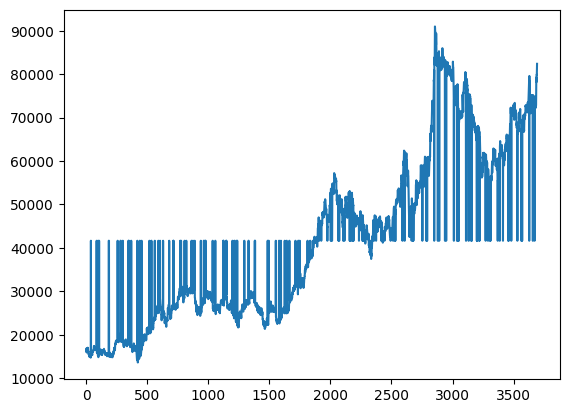

In [14]:
plt.plot(np.arange(len(df)),df['Close'])

In [15]:
class NN_and_data(nn.Module):
    def __init__(self,seq_len,batch_size,lr,input_dim,hidden_dim,hidden_dim2,hidden_dim3,hidden_dim4,output_dim,epochs,data_file
                 ,each_epoch):
        super(NN_and_data,self).__init__()
        
        self.seq_len     = seq_len
        self.batch_size  = batch_size 
        self.input_dim   = input_dim
        self.hidden_dim  = hidden_dim
        self.hidden_dim2 = hidden_dim2
        self.hidden_dim3 = hidden_dim3
        self.hidden_dim4 = hidden_dim4
        self.output_dim  = output_dim
        self.datafile    = data_file


        
        
        self.fc1 = nn.Linear(self.input_dim,self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim,self.hidden_dim2)
        self.fc3 = nn.Linear(self.hidden_dim2,self.hidden_dim3)
        self.fc4 = nn.Linear(self.hidden_dim3,self.hidden_dim4)
        self.fc5 = nn.Linear(self.hidden_dim4,self.output_dim)
     
        
    def Make_window_Data(self):
        privious_day = []
        nextday      = []
        scaler       = MinMaxScaler()
        for index in range(len(self.datafile)-self.seq_len):

            seq_len_data = self.datafile.iloc[index:index+seq_len,:-1]
            next_data    = self.datafile.iloc[index+seq_len,-1]


            sc_seq_len_data = scaler.fit_transform(seq_len_data)

            privious_day.append(sc_seq_len_data)
            nextday.append(next_data)
        return np.array(privious_day),np.array(nextday)

    def Data_and_DataLoader(self):
        x,y      = NN_and_data.Make_window_Data(self)
        
        train_x,test_x,train_y,test_y =  train_test_split(x,y,test_size=0.07,shuffle=False)
        
        train_x = torch.FloatTensor(train_x)
        train_y = torch.FloatTensor(train_y)
        test_x  = torch.FloatTensor(test_x)
        test_y  = torch.FloatTensor(test_y)
        Train_datasets  = TensorDataset(train_x,train_y)
        Test_datasets  = TensorDataset(test_x,test_y)
        

            
        Train_Data_Loader = torch.utils.data.DataLoader(dataset=Train_datasets,batch_size = self.batch_size,
                                                        shuffle = False)
        Test_Data_Loader = torch.utils.data.DataLoader(dataset=Test_datasets,batch_size = self.batch_size,
                                                        shuffle = False)
        return Train_Data_Loader,Test_Data_Loader,test_x,test_y

            
        

    def forward(self,x):

        x = x.view(x.size(0),-1)
#         print(x.size())
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = F.sigmoid(x)
        return x
    
    

In [16]:
class Train_Predict():
    
    def __init__(self,epochs,data_file,each_epoch,seq_len,Data_Loader,criterion):
        
        super(Train_Predict,self).__init__()
        
        self.each_epoch  = each_epoch
        self.lr          = lr
        self.epochs      = epochs
        self.seq_len     = seq_len
        self.Data_Loader = Data_Loader 
        self.criterion   = criterion 
        
    def Training(self):

        optimizer = optim.Adam(model.parameters(),lr=self.lr)
        model.train()

        loss_list = np.zeros(self.epochs)
        check_point = 0
        for i in notebook.tqdm(range(self.epochs)):
            
            avg_loss = 0
            length   = len(self.Data_Loader)

            for data,target in self.Data_Loader:

                target      = target.view(-1,1)
#                 data,target = data.to(device),target.to(device)

                optimizer.zero_grad()

                output = model(data)
                loss   = self.criterion(output,target)
                loss.backward()
                optimizer.step()
                avg_loss += loss.item()/length
                loss_list[i]  = avg_loss

                
            if i%self.each_epoch == 0 and i!=0:
                
#                 print(i,avg_loss)
                
#                 torch.save({'model':'model','epoch':self.epochs,
#                            'model_state_dict':model.state_dict(),
#                            'optimzer_state_dict':optimizer.state_dict(),
#                            'avg_loss':avg_loss,
#                            'check_point':f'custommodel_check_point - {check_point}'
#                            },f'./save/model_{seq_len}_splited_samsung-{check_point}_hidden.pt')
#                 check_point +=1 
                
                if loss_list[i-each_epoch]<loss_list[i]:
                    
                    torch.save({'model':'model','epoch':self.epochs,
                   'model_state_dict':model.state_dict(),
                   'optimzer_state_dict':optimizer.state_dict(),
                   'loss_list':loss_list,
                   },f'./save/model_{seq_len}_splited_samsung_hidden_kopsi,apple_copy.pt')
                    break 
#         torch.save(model,f'./{model}_{seq_len}_splited_apple.pt')
        torch.save({'model':'model','epoch':self.epochs,
               'model_state_dict':model.state_dict(),
               'optimzer_state_dict':optimizer.state_dict(),
               'loss_list':loss_list,
               },f'./save/model_{seq_len}_splited_samsung_hidden_kospi,apple.pt')

        return loss_list

#     def predict(self):

#         model.eval().to(device)
#         test_loss = 0
#         correct   =0

#         with torch.no_grad():

#             for index,(data,label) in enumerate(self.Data_Loader):

#                 data=data.to(device)
#                 label=label.to(device).view(-1,1)

#                 output     = model(data)
#                 test_loss += criterion(output,label).item()
#                 pred       = torch.where(output<0.5,0,1)


#                 correct += pred.eq(label.view_as(pred)).sum().item()

#         accuracy = (100 * correct)/len(self.Data_Loader.dataset)
        
    def predict(self):

        model.eval().to('cpu')
        test_loss = 0
        correct   = 0 
        pred_list = []
        with torch.no_grad():

#             test_x=test_x.to(device)
#             test_y=test_y.to(device).view(-1,1)
            output     = model(test_x)
#             test_loss += criterion(test_x,test_y).item()
            pred       = torch.where(output<0.5,0,1)


            correct    += pred.eq(test_y.view_as(pred)).sum().item()
#             pred_list.append((np.array(pred)).item())
            pred_nump = pred.squeeze().numpy()
        accuracy = (100 * correct)/len(self.Data_Loader.dataset)    
    
        return accuracy,pred_nump

In [17]:
# def predict(self):
    
#     model.eval().to(device)
#     test_loss = 0
#     correct   =0


#     with torch.no_grad():

      

#     data=data.to(device)
#     label=label.to(device).view(-1,1)

#     output     = model(data)
#     test_loss += criterion(output,label).item()
#     pred       = torch.where(output<0.5,0,1)


#     correct += pred.eq(label.view_as(pred)).sum().item()

#     accuracy = (100 * correct)/len(self.Data_Loader.dataset)

In [18]:
seq_len     = 3
batch_size  = 16
input_dim   = seq_len*2
hidden_dim  = 200
hidden_dim2 = 400
hidden_dim3 = 600
hidden_dim4 = 300
output_dim  = 1
lr          = 1e-4
epochs      = 10000
each_epoch  = 100
data_file   = df
criterion = nn.BCELoss()

In [18]:
df.shape

(3693, 22)

In [19]:

seq_list = np.arange(3,14)
accuracy_list = []
pred_dic = {}
for i in seq_list:
    seq_len = i 
#     print(seq_len)
    input_dim = i*21
    
    model = NN_and_data(seq_len,batch_size,lr,input_dim,hidden_dim,hidden_dim2,hidden_dim3,hidden_dim4,output_dim,epochs,data_file
                 ,each_epoch)
    
    Train_Data_Loader,Test_Data_Loader,test_x,test_y = model.Data_and_DataLoader()

    train_tool = Train_Predict(epochs,data_file,each_epoch,seq_len,Train_Data_Loader,criterion)
    loss = train_tool.Training()
    plt.plot(loss)
    plt.title(f'{i}')
    plt.show()
    
    test_tool = Train_Predict(epochs,data_file,each_epoch,seq_len,Test_Data_Loader,criterion)
    
    accuracy,pred_numpy = test_tool.predict()

    pred_dic[i] = pred_numpy
    accuracy_list.append(accuracy)
torch.save(pred_dic,f'pred_samsung_hidden_kospi,apple')

  0%|          | 0/10000 [00:00<?, ?it/s]


KeyboardInterrupt



In [19]:
seq_list = np.arange(3,14)
accuracy_list = []
pred_dic = {}
for i in seq_list:
    seq_len = i 
#     print(seq_len)
    input_dim = i*21
    
    model = NN_and_data(seq_len,batch_size,lr,input_dim,hidden_dim,hidden_dim2,hidden_dim3,hidden_dim4,output_dim,epochs,data_file
                 ,each_epoch)
    
    Train_Data_Loader,Test_Data_Loader,test_x,test_y = model.Data_and_DataLoader()

#     train_tool = Train_Predict(epochs,data_file,each_epoch,seq_len,Train_Data_Loader,criterion)
#     loss = train_tool.Training()
#     plt.plot(loss)
#     plt.title(f'{i}')
#     plt.show()
    
    if seq_len<10:
        
        save_file = torch.load(f'./save/model_{seq_len}_splited_samsung_hidden_kospi,apple.pt')
    else:
        save_file = torch.load(f'./save/model_{seq_len}_splited_samsung_hidden_kospi,apple.pt')

    model.load_state_dict(save_file['model_state_dict'])
    
    test_tool = Train_Predict(epochs,data_file,each_epoch,seq_len,Test_Data_Loader,criterion)
    
    accuracy,pred_numpy = test_tool.predict()

    pred_dic[i] = pred_numpy
    accuracy_list.append(accuracy)
# torch.save(pred_dic,f'pred_samsung_hidden')

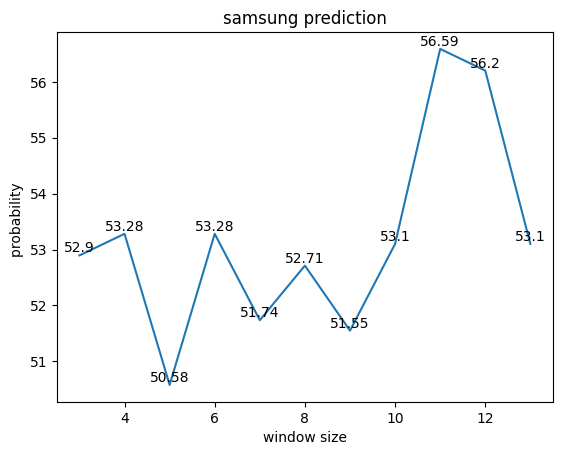

In [20]:
plt.plot(seq_list,accuracy_list)
for i in range(len(accuracy_list)):
    height = round(accuracy_list[i],2)
    plt.text (seq_list[i],height,height, ha='center', va='bottom')
plt.title('samsung prediction')
plt.xlabel('window size')
plt.ylabel('probability ')
plt.show()

In [24]:
# torch.save(accuracy_list,f'./mpl_apple')